In [1]:
pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.9/518.9 kB 39.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 83.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 24.6 MB/s eta 0:00:00


In [2]:
!pip install transformers

In [3]:
!pip install transformers==4.24.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 21.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.31.0
    Uninstalling transformers-4.31.0:
      Successfully uninstalled transformers-4.31.0


In [4]:
 !pip install simpletransformers==0.63.11

In [5]:
import os
import re
import torch
import numpy as np
import pandas as pd

import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem.snowball import SnowballStemmer

import torch

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import f1_score, balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, balanced_accuracy_score
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, TrainerCallback

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 255)

# settings
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams['axes.titlesize'] = 20     # title size
plt.rcParams['axes.labelsize'] = 18     # axis label size
plt.rcParams['xtick.labelsize'] = 15    # x-axis tick label size
plt.rcParams['ytick.labelsize'] = 15    # y-axis tick label size

In [6]:
df =pd.read_csv(r'mtsamples.csv', index_col = "Unnamed: 0")

EDA

In [7]:
# Removing unnecessary spaces

df.columns = df.columns.str.strip()
df = df.drop_duplicates()
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ','_')
df_obj = df.select_dtypes(['object'])
df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())

In [8]:
df['medical_specialty'].unique()

array(['Allergy / Immunology', 'Bariatrics', 'Cardiovascular / Pulmonary',
       'Neurology', 'Dentistry', 'Urology', 'General Medicine', 'Surgery',
       'Speech - Language', 'SOAP / Chart / Progress Notes',
       'Sleep Medicine', 'Rheumatology', 'Radiology',
       'Psychiatry / Psychology', 'Podiatry', 'Physical Medicine - Rehab',
       'Pediatrics - Neonatal', 'Pain Management', 'Orthopedic',
       'Ophthalmology', 'Office Notes', 'Obstetrics / Gynecology',
       'Neurosurgery', 'Nephrology', 'Letters',
       'Lab Medicine - Pathology', 'IME-QME-Work Comp etc.',
       'Hospice - Palliative Care', 'Hematology - Oncology',
       'Gastroenterology', 'ENT - Otolaryngology', 'Endocrinology',
       'Emergency Room Reports', 'Discharge Summary',
       'Diets and Nutritions', 'Dermatology',
       'Cosmetic / Plastic Surgery', 'Consult - History and Phy.',
       'Chiropractic', 'Autopsy'], dtype=object)

In [9]:
df.shape

(4999, 5)

In [10]:
# word count for each medical specialty with their percentage

word_count_list =[]

for medical_specialty in df['medical_specialty'].unique():
    df_filter = df.loc[(df['medical_specialty'] == medical_specialty)]
    word_count_temp = df_filter['transcription'].str.split().str.len().sum()
    word_count_list.append(word_count_temp)

word_count_df = pd.DataFrame({
    'Medical Specialty' : df['medical_specialty'].unique(),
    'Word Count' : word_count_list
})

word_count_df['Word Count'] = word_count_df['Word Count'].astype('int')
word_count_df = word_count_df.sort_values('Word Count', ascending=False)

# Calculate total sum of word count
total_word_count = word_count_df['Word Count'].sum()

# Create new column 'Percentage' with word count percentage
word_count_df['Percentage [%]'] = ((word_count_df['Word Count'] / total_word_count) * 100).round(2)

word_count_df.reset_index(drop=True)

,Medical Specialty,Word Count,Percentage [%]
0,Surgery,526754,22.79
1,Consult - History and Phy.,287961,12.46
2,Orthopedic,198489,8.59
3,Cardiovascular / Pulmonary,160867,6.96
4,General Medicine,120978,5.23
5,Neurology,110677,4.79
6,Gastroenterology,80347,3.48
7,Radiology,74969,3.24
8,Obstetrics / Gynecology,72589,3.14
9,Urology,63419,2.74


In [11]:
# calculating null values
df.isnull().sum().sort_values(ascending = False)

keywords             1068
transcription          33
description             0
medical_specialty       0
sample_name             0
dtype: int64

In [12]:
# removing transcription rows that is empty
df = df[df['transcription'].notna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4966 entries, 0 to 4998
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   description        4966 non-null   object
 1   medical_specialty  4966 non-null   object
 2   sample_name        4966 non-null   object
 3   transcription      4966 non-null   object
 4   keywords           3898 non-null   object
dtypes: object(5)
memory usage: 232.8+ KB


In [13]:
# drop redundant columns
df =df.drop(['description','sample_name','keywords'], axis=1)
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female presents with complaint of allergies. She used to have allergies when she lived in Seattle but she thinks they are worse here. In the past, she has tried Claritin, and Zyrtec. Both worked for short time b..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. He exercises three times a week at home and does cardio. He has difficulty walking two b..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC today. He is a very pleasant gentleman who is 42 years old, 344 pounds. He is 5'9"". He has a BMI of 51. He has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement with left atrial diameter of 4.7 cm.,2. Normal size right and left ventricle.,3. Normal LV systolic function with left ventricular ejection fraction of 51%.,4. Normal LV diastolic function.,5. No pericard..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall thickness appear normal. The wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. There is near-cavity obliteration seen. There also ap...


Normaliztion

In [14]:
# converting into lowercase
def lower(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : str.lower(x))
    return df

df = lower(df,'transcription')
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"subjective:, this 23-year-old white female presents with complaint of allergies. she used to have allergies when she lived in seattle but she thinks they are worse here. in the past, she has tried claritin, and zyrtec. both worked for short time b..."
1,Bariatrics,"past medical history:, he has difficulty climbing stairs, difficulty with airline seats, tying shoes, used to public seating, and lifting objects off the floor. he exercises three times a week at home and does cardio. he has difficulty walking two b..."
2,Bariatrics,"history of present illness: , i have seen abc today. he is a very pleasant gentleman who is 42 years old, 344 pounds. he is 5'9"". he has a bmi of 51. he has been overweight for ten years since the age of 33, at his highest he was 358 pounds, at hi..."
3,Cardiovascular / Pulmonary,"2-d m-mode: , ,1. left atrial enlargement with left atrial diameter of 4.7 cm.,2. normal size right and left ventricle.,3. normal lv systolic function with left ventricular ejection fraction of 51%.,4. normal lv diastolic function.,5. no pericard..."
4,Cardiovascular / Pulmonary,1. the left ventricular cavity size and wall thickness appear normal. the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of 70% to 75%. there is near-cavity obliteration seen. there also ap...


In [15]:
# removing transcription punctuation and numbers

def remove_punc_num(df, attribute):
    df.loc[:,attribute] = df[attribute].apply(lambda x : " ".join(re.findall('[\w]+',x)))
    df[attribute] = df[attribute].str.replace('\d+', '')
    return df

df = remove_punc_num(df, 'transcription')
df_no_punc =df.copy()
df.head()

,medical_specialty,transcription
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seeme...
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surg...
3,Cardiovascular / Pulmonary,d m mode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morpholo...
4,Cardiovascular / Pulmonary,the left ventricular cavity size and wall thickness appear normal the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to there is near cavity obliteration seen there also appears to be inc...


In [16]:
# tokenising transcription

tk =WhitespaceTokenizer()
def tokenise(df, attribute):
    df['tokenised'] = df.apply(lambda row: tk.tokenize(str(row[attribute])), axis=1)
    return df

df =tokenise(df, 'transcription')
df_experiment =df.copy()
df.head()

,medical_specialty,transcription,tokenised
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seeme...,"[subjective, this, year, old, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...,"[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surg...,"[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun..."
3,Cardiovascular / Pulmonary,d m mode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morpholo...,"[d, m, mode, left, atrial, enlargement, with, left, atrial, diameter, of, cm, normal, size, right, and, left, ventricle, normal, lv, systolic, function, with, left, ventricular, ejection, fraction, of, normal, lv, diastolic, function, no, pericardial,..."
4,Cardiovascular / Pulmonary,the left ventricular cavity size and wall thickness appear normal the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to there is near cavity obliteration seen there also appears to be inc...,"[the, left, ventricular, cavity, size, and, wall, thickness, appear, normal, the, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, to, there, is, near, cavity, obliteration, seen..."


In [17]:
# stemming

def stemming(df, attribute):
    # Use English stemmer.
    stemmer = SnowballStemmer("english")
    df['stemmed'] = df[attribute].apply(lambda x: [stemmer.stem(y) for y in x]) # Stem every word.
    return df

df =stemming(df_experiment, 'tokenised')
df.head()

,medical_specialty,transcription,tokenised,stemmed
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seeme...,"[subjective, this, year, old, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both...","[subject, this, year, old, white, femal, present, with, complaint, of, allergi, she, use, to, have, allergi, when, she, live, in, seattl, but, she, think, they, are, wors, here, in, the, past, she, has, tri, claritin, and, zyrtec, both, work, for, sho..."
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...,"[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h...","[past, medic, histori, he, has, difficulti, climb, stair, difficulti, with, airlin, seat, tie, shoe, use, to, public, seat, and, lift, object, off, the, floor, he, exercis, three, time, a, week, at, home, and, doe, cardio, he, has, difficulti, walk, t..."
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surg...,"[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[histori, of, present, ill, i, have, seen, abc, today, he, is, a, veri, pleasant, gentleman, who, is, year, old, pound, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, year, sinc, the, age, of, at, his, highest, he, was, pound, at, h..."
3,Cardiovascular / Pulmonary,d m mode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morpholo...,"[d, m, mode, left, atrial, enlargement, with, left, atrial, diameter, of, cm, normal, size, right, and, left, ventricle, normal, lv, systolic, function, with, left, ventricular, ejection, fraction, of, normal, lv, diastolic, function, no, pericardial,...","[d, m, mode, left, atrial, enlarg, with, left, atrial, diamet, of, cm, normal, size, right, and, left, ventricl, normal, lv, systol, function, with, left, ventricular, eject, fraction, of, normal, lv, diastol, function, no, pericardi, effus, normal, m..."
4,Cardiovascular / Pulmonary,the left ventricular cavity size and wall thickness appear normal the wall motion and left ventricular systolic function appears hyperdynamic with estimated ejection fraction of to there is near cavity obliteration seen there also appears to be inc...,"[the, left, ventricular, cavity, size, and, wall, thickness, appear, normal, the, wall, motion, and, left, ventricular, systolic, function, appears, hyperdynamic, with, estimated, ejection, fraction, of, to, there, is, near, cavity, obliteration, seen...","[the, left, ventricular, caviti, size, and, wall, thick, appear, normal, the, wall, motion, and, left, ventricular, systol, function, appear, hyperdynam, with, estim, eject, fraction, of, to, there, is, near, caviti, obliter, seen, there, also, appear..."


In [18]:
import nltk

In [19]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
# removing stop words
stop = stopwords.words('english')
print(f"Total stop words = {len(stop)}  \n")
print(stop)

Total stop words = 179  

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own

In [21]:
def remove_stop_words(df, attribute):
    stop = stopwords.words('english')
    df['stemmed_without_stop'] = df[attribute].apply(lambda x: ' '.join([word for word in x if word not in (stop)]))
    return df

df = remove_stop_words(df, 'stemmed')
df.head()

,medical_specialty,transcription,tokenised,stemmed,stemmed_without_stop
0,Allergy / Immunology,subjective this year old white female presents with complaint of allergies she used to have allergies when she lived in seattle but she thinks they are worse here in the past she has tried claritin and zyrtec both worked for short time but then seeme...,"[subjective, this, year, old, white, female, presents, with, complaint, of, allergies, she, used, to, have, allergies, when, she, lived, in, seattle, but, she, thinks, they, are, worse, here, in, the, past, she, has, tried, claritin, and, zyrtec, both...","[subject, this, year, old, white, femal, present, with, complaint, of, allergi, she, use, to, have, allergi, when, she, live, in, seattl, but, she, think, they, are, wors, here, in, the, past, she, has, tri, claritin, and, zyrtec, both, work, for, sho...",subject year old white femal present complaint allergi use allergi live seattl think wors past tri claritin zyrtec work short time seem lose effect use allegra also use last summer began use two week ago doe appear work veri well use counter spray pre...
1,Bariatrics,past medical history he has difficulty climbing stairs difficulty with airline seats tying shoes used to public seating and lifting objects off the floor he exercises three times a week at home and does cardio he has difficulty walking two blocks or f...,"[past, medical, history, he, has, difficulty, climbing, stairs, difficulty, with, airline, seats, tying, shoes, used, to, public, seating, and, lifting, objects, off, the, floor, he, exercises, three, times, a, week, at, home, and, does, cardio, he, h...","[past, medic, histori, he, has, difficulti, climb, stair, difficulti, with, airlin, seat, tie, shoe, use, to, public, seat, and, lift, object, off, the, floor, he, exercis, three, time, a, week, at, home, and, doe, cardio, he, has, difficulti, walk, t...",past medic histori difficulti climb stair difficulti airlin seat tie shoe use public seat lift object floor exercis three time week home doe cardio difficulti walk two block five flight stair difficulti snore muscl joint pain includ knee pain back pai...
2,Bariatrics,history of present illness i have seen abc today he is a very pleasant gentleman who is years old pounds he is he has a bmi of he has been overweight for ten years since the age of at his highest he was pounds at his lowest he is pursuing surg...,"[history, of, present, illness, i, have, seen, abc, today, he, is, a, very, pleasant, gentleman, who, is, years, old, pounds, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, years, since, the, age, of, at, his, highest, he, was, poun...","[histori, of, present, ill, i, have, seen, abc, today, he, is, a, veri, pleasant, gentleman, who, is, year, old, pound, he, is, he, has, a, bmi, of, he, has, been, overweight, for, ten, year, sinc, the, age, of, at, his, highest, he, was, pound, at, h...",histori present ill seen abc today veri pleasant gentleman year old pound bmi overweight ten year sinc age highest pound lowest pursu surgic attempt weight loss feel good get healthi begin exercis want abl exercis play volleybal physic sluggish get ti...
3,Cardiovascular / Pulmonary,d m mode left atrial enlargement with left atrial diameter of cm normal size right and left ventricle normal lv systolic function with left ventricular ejection fraction of normal lv diastolic function no pericardial effusion normal morpholo...,"[d, m, mode, left, atrial, enlargement, with, left, atrial, diameter, of, cm, normal, size, right, and, left, ventricle, normal, lv, systolic, function, with, left, ventricular, ejection, fraction, of, normal, lv, diastolic, function, no, pericardial,...","[d, m, mode, left, atrial, enlarg, with, left, atrial, diamet, of, cm, normal, size, right, and, left, ventricl, normal, lv, systol, function, with, left, ventricular, eject, fraction, of, normal, lv, diastol, function, no, pericardi, effus, normal, m...",mode left atrial enlarg left

In [22]:
df =df.drop(['transcription','stemmed', 'tokenised'], axis=1)
df.head()

,medical_specialty,stemmed_without_stop
0,Allergy / Immunology,subject year old white femal present complaint allergi use allergi live seattl think wors past tri claritin zyrtec work short time seem lose effect use allegra also use last summer began use two week ago doe appear work veri well use counter spray pre...
1,Bariatrics,past medic histori difficulti climb stair difficulti airlin seat tie shoe use public seat lift object floor exercis three time week home doe cardio difficulti walk two block five flight stair difficulti snore muscl joint pain includ knee pain back pai...
2,Bariatrics,histori present ill seen abc today veri pleasant gentleman year old pound bmi overweight ten year sinc age highest pound lowest pursu surgic attempt weight loss feel good get healthi begin exercis want abl exercis play volleybal physic sluggish get ti...
3,Cardiovascular / Pulmonary,mode left atrial enlarg left atrial diamet cm normal size right left ventricl normal lv systol function left ventricular eject fraction normal lv diastol function pericardi effus normal morpholog aortic valv mitral valv tricuspid valv pulmonari valv p...
4,Cardiovascular / Pulmonary,left ventricular caviti size wall thick appear normal wall motion left ventricular systol function appear hyperdynam estim eject fraction near caviti obliter seen also appear increas left ventricular outflow tract gradient mid caviti level consist hyp...


In [23]:
# Label Encoding

le = preprocessing.LabelEncoder()
le.fit(df['medical_specialty'])
df['encoded_target'] = le.transform(df['medical_specialty'])
df.head()

,medical_specialty,stemmed_without_stop,encoded_target
0,Allergy / Immunology,subject year old white femal present complaint allergi use allergi live seattl think wors past tri claritin zyrtec work short time seem lose effect use allegra also use last summer began use two week ago doe appear work veri well use counter spray pre...,0
1,Bariatrics,past medic histori difficulti climb stair difficulti airlin seat tie shoe use public seat lift object floor exercis three time week home doe cardio difficulti walk two block five flight stair difficulti snore muscl joint pain includ knee pain back pai...,2
2,Bariatrics,histori present ill seen abc today veri pleasant gentleman year old pound bmi overweight ten year sinc age highest pound lowest pursu surgic attempt weight loss feel good get healthi begin exercis want abl exercis play volleybal physic sluggish get ti...,2
3,Cardiovascular / Pulmonary,mode left atrial enlarg left atrial diamet cm normal size right left ventricl normal lv systol function left ventricular eject fraction normal lv diastol function pericardi effus normal morpholog aortic valv mitral valv tricuspid valv pulmonari valv p...,3
4,Cardiovascular / Pulmonary,left ventricular caviti size wall thick appear normal wall motion left ventricular systol function appear hyperdynam estim eject fraction near caviti obliter seen also appear increas left ventricular outflow tract gradient mid caviti level consist hyp...,3


In [24]:
def bar_plot(df, column_name, vertical=False, title=None, x_label=None, y_label=None, xticks_rotation=0):
    """
    Function to create a bar plot for a specific DataFrame column with count labels.
    :param df: pandas DataFrame
    :param column_name: String, the column name in the DataFrame
    :param vertical: Boolean, whether to rotate the x-axis labels and make the bar plot horizontal
    :param title: String, the title of the plot
    :param x_label: String, the label for the x-axis
    :param y_label: String, the label for the y-axis
    :param xticks_rotation: Int or float, the rotation angle for x-axis labels
    :return: None
    """
    # Count the unique values in the column
    value_counts = df[column_name].value_counts()

    if vertical:
        # Create the bar plot with horizontal bars
        # plt.figure()
        bars = plt.barh(value_counts.index, value_counts.values, color='skyblue')

        # Add the count labels next to the bars
        for bar in bars:
            plt.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, bar.get_width(), ha='left', va='center', fontsize = 14)

        # Set plot title and labels
        plt.title(title or 'Bar plot for column ' + column_name)
        plt.xlabel(x_label or 'Counts')
        plt.ylabel(y_label or column_name)

    else:
        # Create the bar plot with vertical bars
        # plt.figure()
        bars = plt.bar(value_counts.index, value_counts.values, color='skyblue')

        # Add the count labels above the bars
        for bar in bars:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, bar.get_height(), ha='center', va='bottom', fontsize = 14)

        # Set plot title and labels
        plt.title(title or 'Bar plot for column ' + column_name)
        plt.xlabel(x_label or column_name)
        plt.ylabel(y_label or 'Counts')

        # Rotate x-axis labels if requested
        plt.xticks(rotation=xticks_rotation)

    # Show the plot
    plt.tight_layout()
    plt.show()

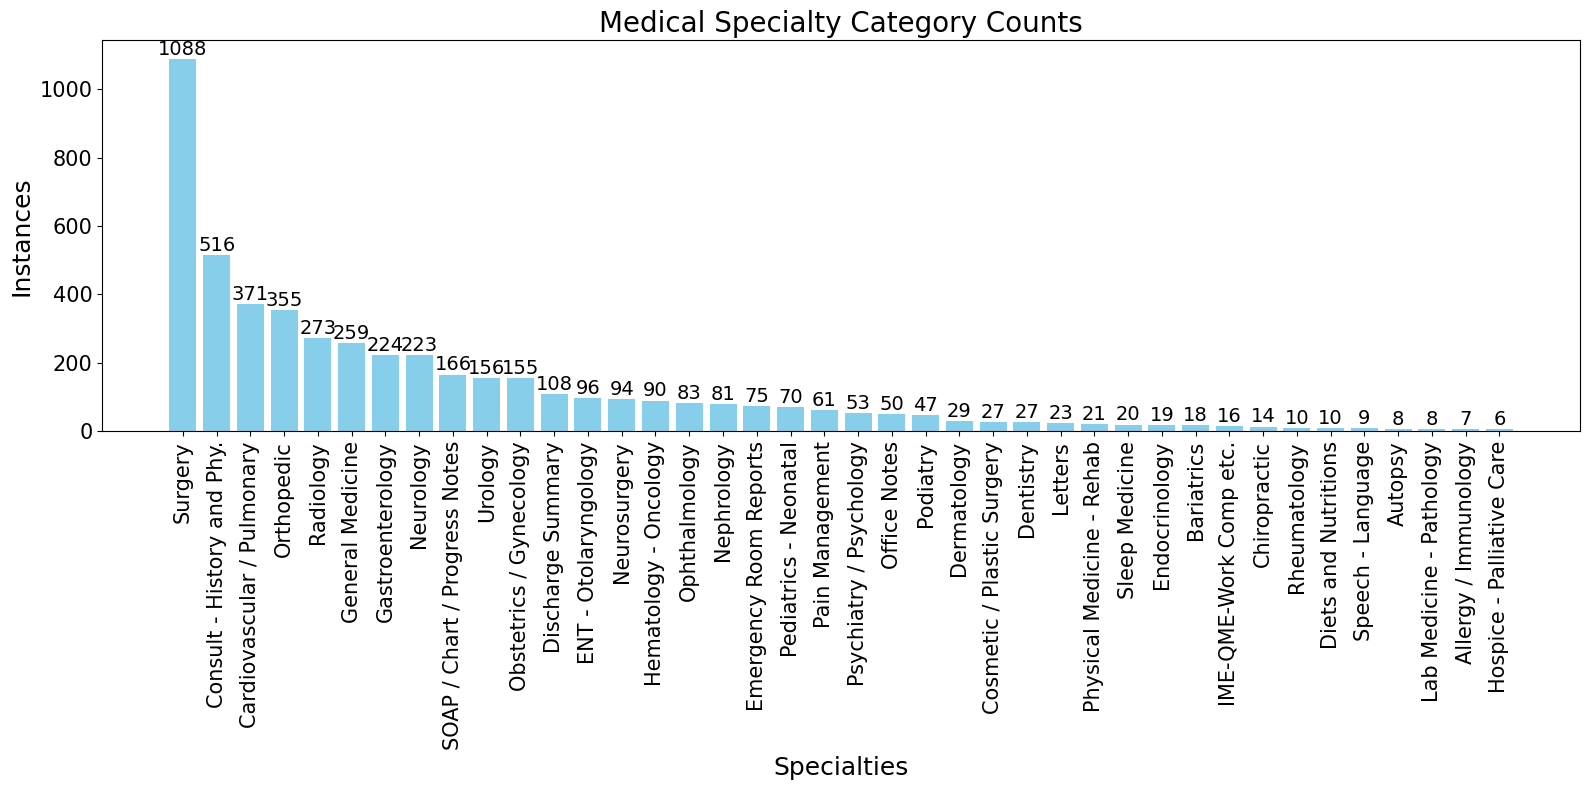

In [25]:
bar_plot(df, 'medical_specialty', vertical=False, title='Medical Specialty Category Counts',
        x_label='Specialties', y_label='Instances', xticks_rotation=90)

Modeling

In [26]:
# Split the data into temporary train and final test sets
temp_train_texts, test_texts, temp_train_labels, test_labels = train_test_split(
    df['stemmed_without_stop'], df['encoded_target'], test_size=0.2, random_state=42)

# Split the temporary training set into final train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    temp_train_texts, temp_train_labels, test_size=0.25, random_state=42)

In [27]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [28]:
# Tokenize the data
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)

In [29]:
# Convert our data into torch Dataset
class MedDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MedDataset(train_encodings, train_labels.tolist())
val_dataset = MedDataset(val_encodings, val_labels.tolist())

In [30]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []
        self.eval_accuracy = []

    def on_train_begin(self, args, state, control, **kwargs):
        print("Training begins...")

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_loss.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_loss.append(logs['eval_loss'])
        if 'eval_accuracy' in logs:
            self.eval_accuracy.append(logs['eval_accuracy'])

In [31]:
# Specify the training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    no_cuda=True,
    report_to=[]  # Add this line to disable wandb logging
)

In [32]:
# Load the base BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = df['encoded_target'].nunique())

# Initialize the Trainer
metrics_callback = MetricsCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[metrics_callback]
)

# Train the model
trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Training begins...


Step,Training Loss
500,2.703700


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=561, training_loss=2.637491426790887, metrics={'train_runtime': 17636.2541, 'train_samples_per_second': 0.507, 'train_steps_per_second': 0.032, 'total_flos': 2352225776099328.0, 'train_loss': 2.637491426790887, 'epoch': 3.0})

In [33]:
# Tokenize the test data
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=512)

# Convert the test data to a Dataset object
test_dataset = MedDataset(test_encodings, test_labels.tolist())

# Evaluate the model
eval_results = trainer.evaluate(eval_dataset=test_dataset)

print(f"Evaluation loss: {eval_results['eval_loss']}")

# Make predictions
predictions = trainer.predict(test_dataset)

# The predictions are in logits (i.e., before the softmax) so you need to apply softmax to get probabilities
probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions.predictions), dim=-1)

# Get the predicted classes
predicted_classes = torch.argmax(probabilities, dim=-1)

***** Running Evaluation *****
  Num examples = 994
  Batch size = 64


***** Running Prediction *****
  Num examples = 994
  Batch size = 64


Evaluation loss: 1.9897303581237793


In [34]:
def eval_metrics(actual, pred):
    bal_acc = balanced_accuracy_score(actual,pred)
    f1_sc = f1_score(actual,pred,average="micro")
    return bal_acc, f1_sc

In [35]:
# Compute accuracy and f1 score
acc, f1 = eval_metrics(test_labels, predicted_classes)

print(f' Accuracy = {acc} \n F1 Score = {f1}')

 Accuracy = 0.11960663873172783 
 F1 Score = 0.36116700201207247


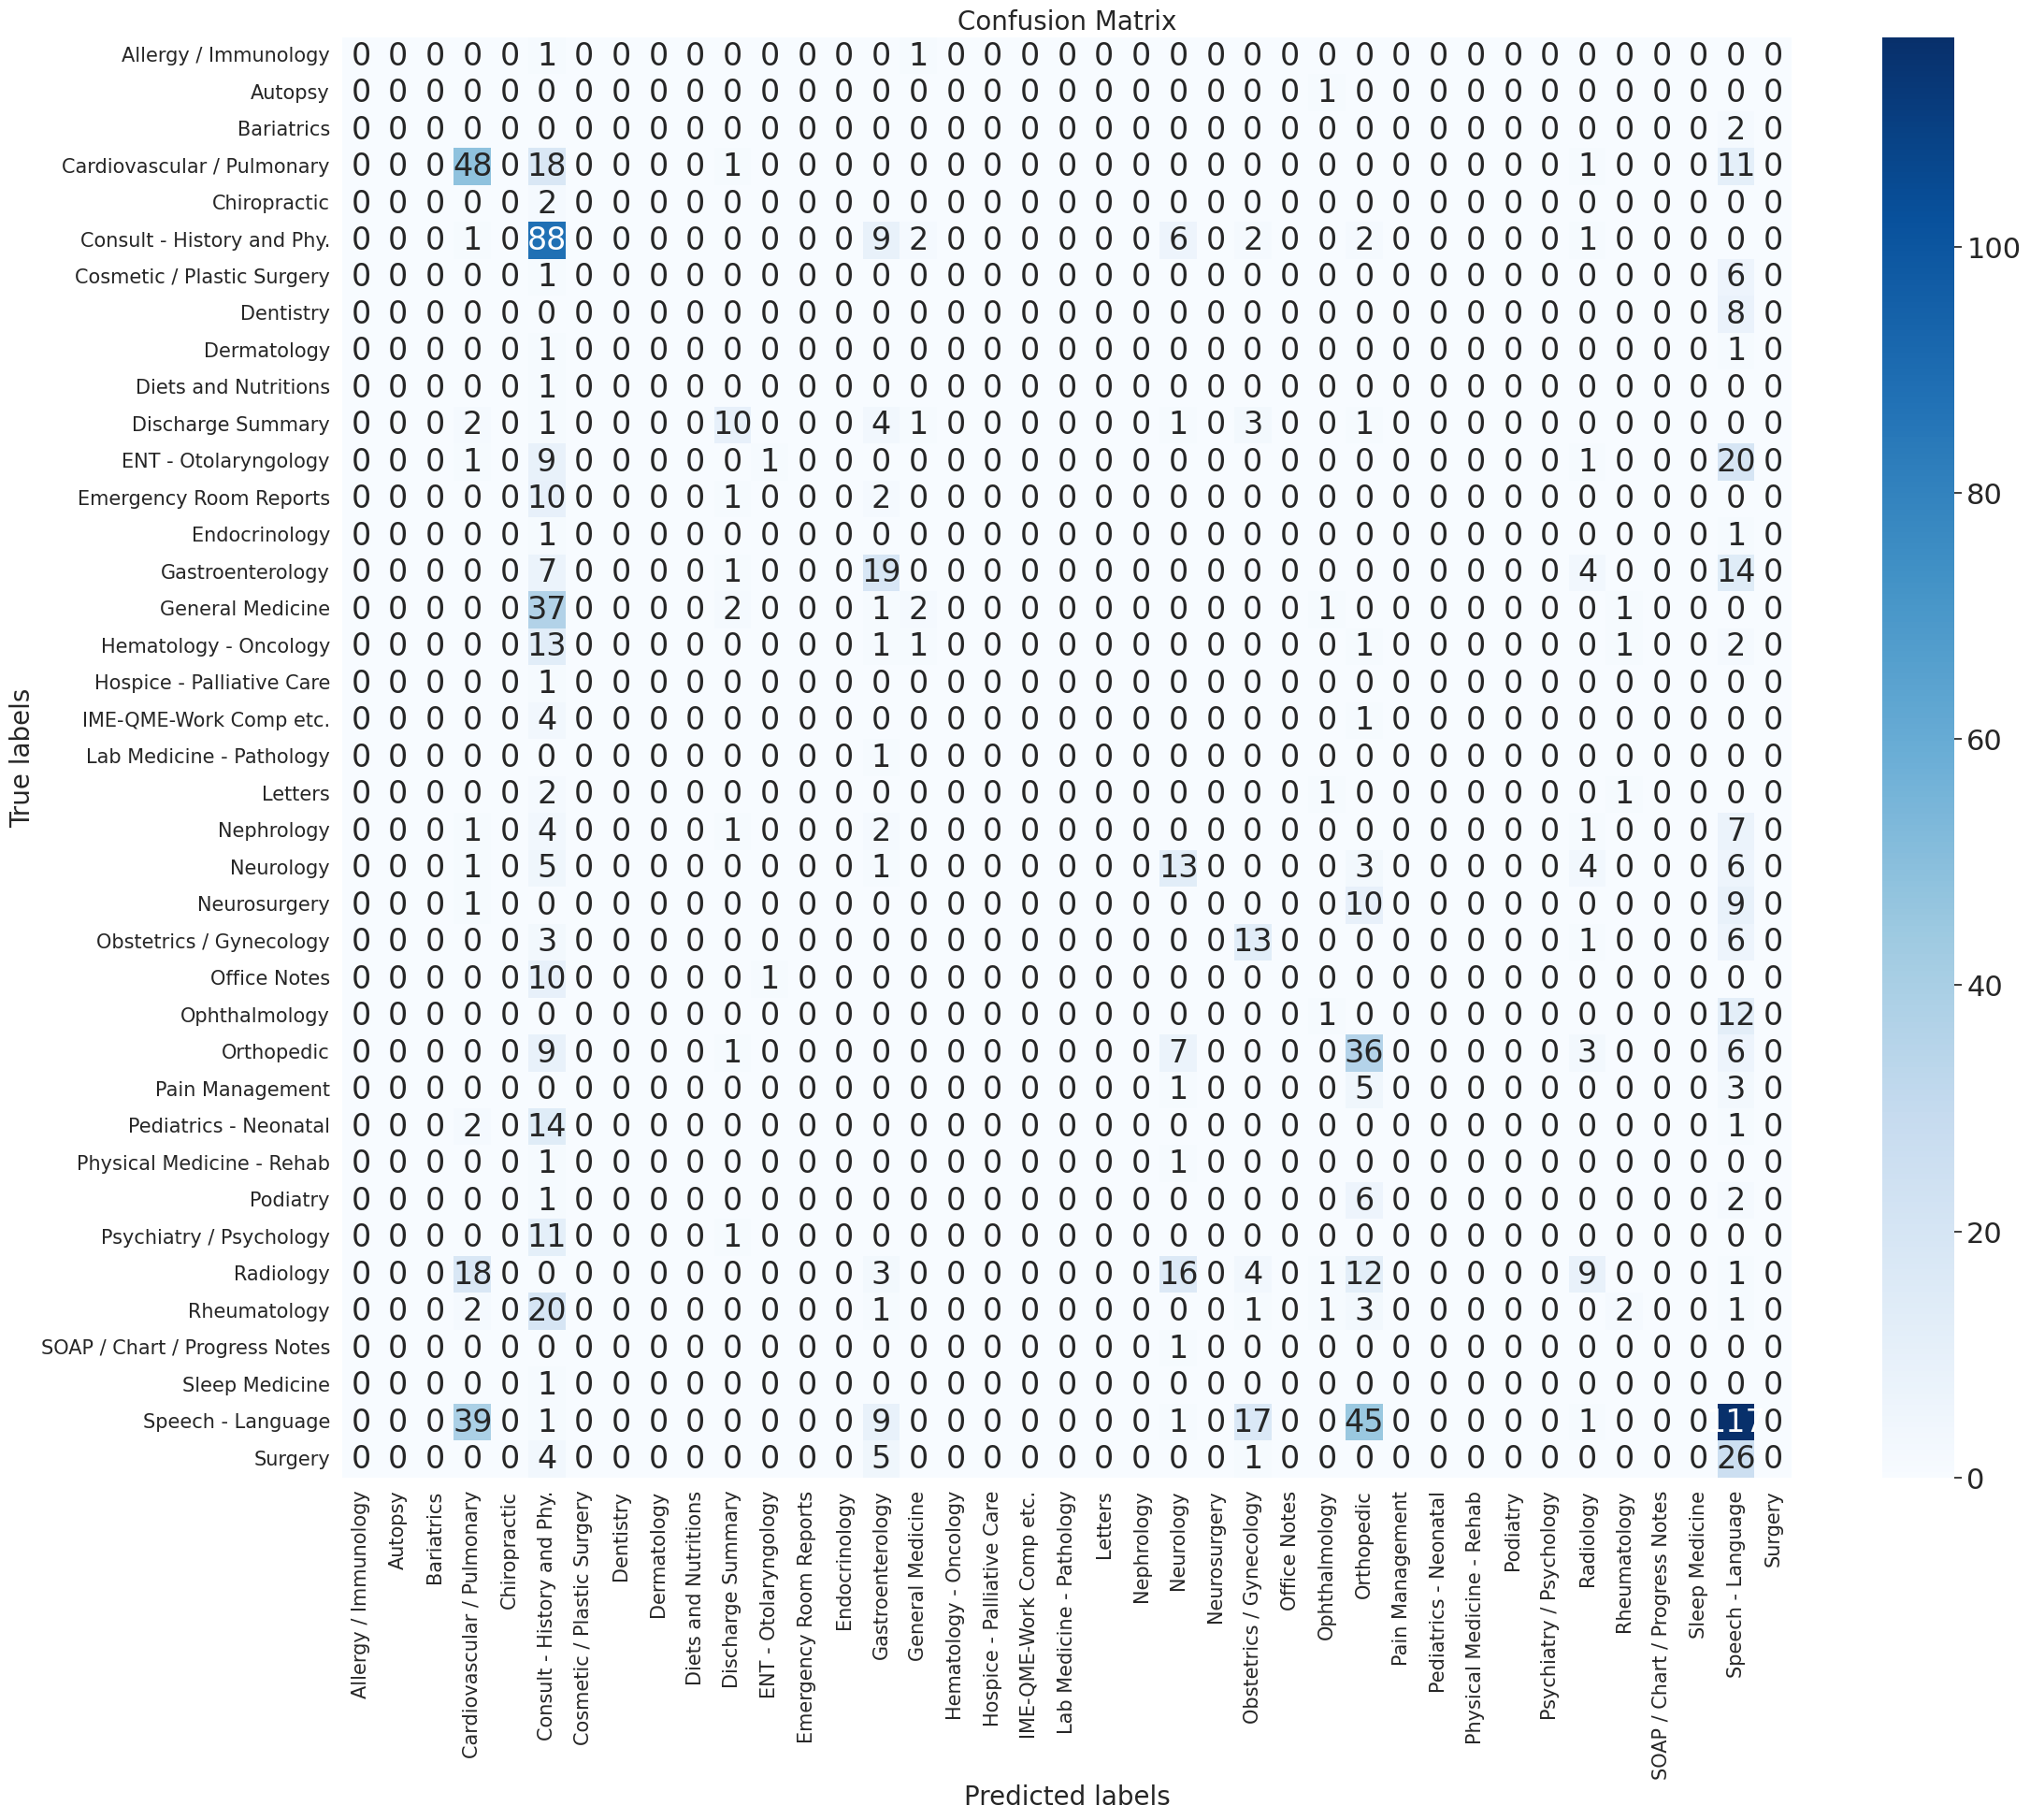

In [38]:
# Confusion Matrix
cm = confusion_matrix(test_labels, predicted_classes)

plt.figure(figsize=(25, 20))
ax = plt.subplot()
sns.set(font_scale=2)
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues", ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20)

ax.set_title('Confusion Matrix', fontsize=20)

ax.xaxis.set_ticklabels(np.sort(df['medical_specialty'].unique())[:-1], fontsize=15, rotation = 90)
ax.yaxis.set_ticklabels(np.sort(df['medical_specialty'].unique())[:-1], fontsize=15, rotation = 0)

plt.show()

Balanced Data

In [39]:
df['medical_specialty'].value_counts()

Surgery                          1088
Consult - History and Phy.        516
Cardiovascular / Pulmonary        371
Orthopedic                        355
Radiology                         273
General Medicine                  259
Gastroenterology                  224
Neurology                         223
SOAP / Chart / Progress Notes     166
Urology                           156
Obstetrics / Gynecology           155
Discharge Summary                 108
ENT - Otolaryngology               96
Neurosurgery                       94
Hematology - Oncology              90
Ophthalmology                      83
Nephrology                         81
Emergency Room Reports             75
Pediatrics - Neonatal              70
Pain Management                    61
Psychiatry / Psychology            53
Office Notes                       50
Podiatry                           47
Dermatology                        29
Cosmetic / Plastic Surgery         27
Dentistry                          27
Letters     